<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-walkthrough" data-toc-modified-id="Data-walkthrough-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data walkthrough</a></span></li><li><span><a href="#Helpers-functions" data-toc-modified-id="Helpers-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helpers functions</a></span></li><li><span><a href="#Base-models" data-toc-modified-id="Base-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Base models</a></span></li><li><span><a href="#Data-engineering" data-toc-modified-id="Data-engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data engineering</a></span><ul class="toc-item"><li><span><a href="#Reorder-data" data-toc-modified-id="Reorder-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Reorder data</a></span></li></ul></li><li><span><a href="#Confidence-based-on-tree-variance" data-toc-modified-id="Confidence-based-on-tree-variance-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Confidence based on tree variance</a></span></li><li><span><a href="#Feature-Important" data-toc-modified-id="Feature-Important-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Important</a></span><ul class="toc-item"><li><span><a href="#One-hot-encoding" data-toc-modified-id="One-hot-encoding-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>One-hot encoding</a></span></li></ul></li><li><span><a href="#Removing-redundant-features" data-toc-modified-id="Removing-redundant-features-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Removing redundant features</a></span></li><li><span><a href="#Tree-interpreter" data-toc-modified-id="Tree-interpreter-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Tree interpreter</a></span></li><li><span><a href="#Extrapolation" data-toc-modified-id="Extrapolation-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Extrapolation</a></span></li><li><span><a href="#Final-model" data-toc-modified-id="Final-model-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Final model</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFF

from pprint import pprint

plt.rcParams["figure.figsize"] = (15,6)

In [2]:
import sys
sys.path.append('..')

from fastai.structured import *

In [3]:
df_raw = pd.read_feather('../data/train')

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [231]:
df_raw.rename(columns={'totals_transactionRevenue':'Revenue'},inplace=True)
df_raw.columns

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'visitId', 'visitNumber', 'visitStartTime', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'device_browser', 'device_browserSize',
       'device_browserVersion', 'device_deviceCategory', 'device_flashVersion',
       'device_isMobile', 'device_language', 'device_mobileDeviceBranding',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_screenColors', 'device_screenResolution', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_network

### Data walkthrough

In [232]:
df_raw.head()

,channelGrouping,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,Year,Month,Week,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,1131660440785968503,1131660440785968503_1472830385,NA,1472830385,1,1472830385,2016,9,35,...,NaN,NaN,NaN,NA,NaN,NaN,NA,organic,NaN,google
1,Organic Search,377306020877927890,377306020877927890_1472880147,NA,1472880147,1,1472880147,2016,9,35,...,NaN,NaN,NaN,NA,NaN,NaN,NA,organic,NaN,google
2,Organic Search,3895546263509774583,3895546263509774583_1472865386,NA,1472865386,1,1472865386,2016,9,35,...,NaN,NaN,NaN,NA,NaN,NaN,NA,organic,NaN,google
3,Organic Search,4763447161404445595,4763447161404445595_1472881213,NA,1472881213,1,1472881213,2016,9,35,...,NaN,NaN,NaN,NA,NaN,NaN,google + online,organic,NaN,google
4,Organic Search,27294437909732085,27294437909732085_1472822600,NA,1472822600,2,1472822600,2016,9,35,...,NaN,NaN,NaN,NA,NaN,True,NA,organic,NaN,google


In [6]:
df_raw.describe(include='all')

,channelGrouping,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,Year,Month,Week,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
count,100000,100000,100000,100000,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.00000,...,2574,2574,2574,100000,1,30454,44218,100000,36473,100000
unique,8,89213,99993,1,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4,2,8,1,1,643,7,527,161
top,Organic Search,1957458976293878100,7817946123013268752_1480492790,NA,NaN,NaN,NaN,NaN,NaN,NaN,...,False,1,Top,NA,11251kjhkvahf,True,NA,organic,/,google
freq,42019,44,2,100000,NaN,NaN,NaN,NaN,NaN,NaN,...,2574,2566,2527,95442,1,30454,40273,42019,8731,44448
mean,NaN,NaN,NaN,NaN,1.484710e+09,2.274210,1.484710e+09,2016.459050,7.520690,30.91058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,9.166865e+06,9.260941,9.166865e+06,0.498323,3.386258,14.85400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.470896e+09,1.000000,1.470899e+09,2016.000000,1.000000,2.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.478832e+09,1.000000,1.478832e+09,2016.000000,5.000000,20.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.481667e+09,1.000000,1.481667e+09,2016.000000,8.000000,33.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.493684e+09,1.000000,1.493684e+09,2017.000000,11.000000,46.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_raw.isnull().sum().sort_values()

channelGrouping                                          0
device_mobileDeviceMarketingName                         0
device_mobileDeviceModel                                 0
device_mobileInputSelector                               0
device_operatingSystem                                   0
device_screenColors                                      0
device_screenResolution                                  0
geoNetwork_city                                          0
geoNetwork_cityId                                        0
geoNetwork_continent                                     0
geoNetwork_country                                       0
geoNetwork_latitude                                      0
geoNetwork_longitude                                     0
geoNetwork_metro                                         0
geoNetwork_networkDomain                                 0
geoNetwork_networkLocation                               0
geoNetwork_region                                       

# Helpers functions

In [8]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = {'rmse_train':rmse(m.predict(X_train), y_train), 'rmse_valid':rmse(m.predict(X_valid), y_valid),
                'r2_train':m.score(X_train, y_train), 'r2_valid':m.score(X_valid, y_valid)}
    if hasattr(m, 'oob_score_'): res['r2_oob']= m.oob_score_
    pprint(res)

In [214]:
def base_model(oob_score=True):
    global m
    m = RFF(n_jobs=-1,n_estimators=20,oob_score=oob_score)
    m.fit(X_train, y_train)
    print_score(m)

In [66]:
n_trn = 70000

def split_vals(a,n) : return a[:n],a[n:]

def split_data(n_trn = 70000,to_keep=None):
    global X_train,X_valid,y_train,y_valid,raw_train,raw_valid,df_trn,y_trn
    
    raw_train, raw_valid = split_vals(df_raw, n_trn)
    
    df_trn, y_trn, nas = proc_df(df_raw, 'Revenue')
    
    if to_keep is not None:
        df_trn = df_trn[to_keep].copy()
    
    y_trn = np.log1p(y_trn)
    
    X_train, X_valid = split_vals(df_trn, n_trn)
    y_train, y_valid = split_vals(y_trn, n_trn)
    
    

In [11]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

# Base models

In [36]:
split_data()

In [37]:
base_model()

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'r2_oob': 0.16297263199118905,
 'r2_train': 0.8810752181855306,
 'r2_valid': 0.2573883904293486,
 'rmse_train': 0.6890227071948529,
 'rmse_valid': 1.9962417315766017}


# Data engineering

## Reorder data

In [14]:
df_raw.columns

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'visitId', 'visitNumber', 'visitStartTime', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'device_browser', 'device_browserSize',
       'device_browserVersion', 'device_deviceCategory', 'device_flashVersion',
       'device_isMobile', 'device_language', 'device_mobileDeviceBranding',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_screenColors', 'device_screenResolution', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_network

In [15]:
to_sort = ['totals_pageviews','totals_hits']
for cat in to_sort:
    orders = np.array(sorted(df_raw[cat].cat.categories.astype(np.int32))).astype(np.str)
    df_raw[cat].cat.reorder_categories(orders,inplace=True)

In [16]:
split_data()

In [38]:
base_model()

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'r2_oob': 0.1686974258099353,
 'r2_train': 0.8804045738778736,
 'r2_valid': 0.2449195532676807,
 'rmse_train': 0.690962755025633,
 'rmse_valid': 2.01293093922232}


Much better when do this haha

# Confidence based on tree variance

In [213]:
base_model()

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'r2_oob': 0.13838250722902623,
 'r2_train': 0.8747750315827627,
 'r2_valid': 0.2095851047911721,
 'rmse_train': 0.707038101962937,
 'rmse_valid': 2.059490632840232}


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [214]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 38.7 ms, sys: 52.1 ms, total: 90.8 ms
Wall time: 148 ms


(0.89056615537573, 3.8818878738203493)

The results is just terible

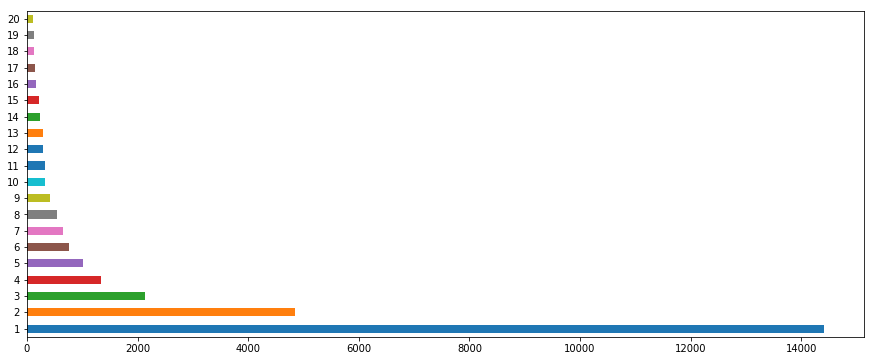

In [215]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.totals_hits.value_counts()[:20].plot.barh();

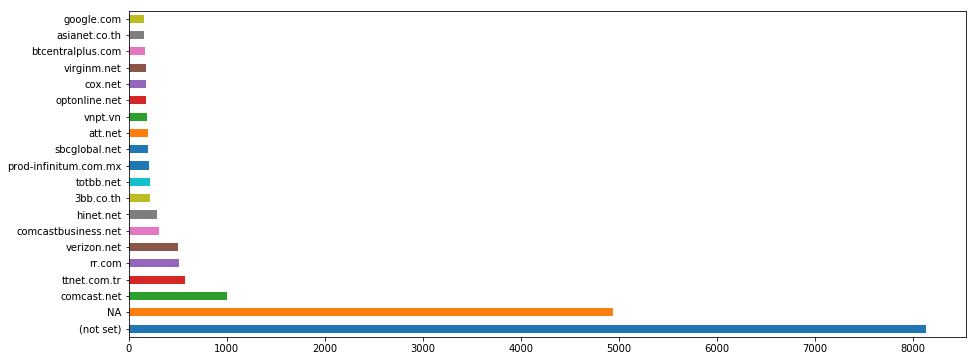

In [216]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.geoNetwork_networkDomain.value_counts()[:20].plot.barh();

# Feature Important

In [85]:
split_data()
base_model()

{'r2_oob': 0.17406764389419582,
 'r2_train': 0.8824749963432134,
 'r2_valid': 0.23820778425879696,
 'rmse_train': 0.6849557087347439,
 'rmse_valid': 2.021857430138216}


In [86]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
50,totals_pageviews,0.245791
48,totals_hits,0.066034
6,visitStartTime,0.060605
2,sessionId,0.060212
39,geoNetwork_country,0.056124
1,fullVisitorId,0.055513
4,visitId,0.053637
43,geoNetwork_networkDomain,0.038531
5,visitNumber,0.035169
36,geoNetwork_city,0.029837


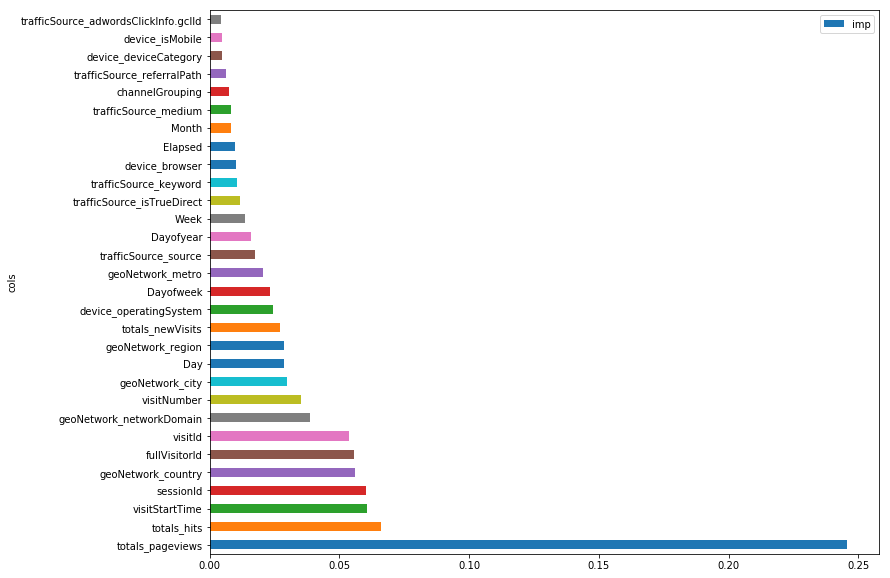

In [87]:
fi[:30].plot(x='cols',y='imp',kind='barh',figsize=(12,10))

Try delete some columns

In [90]:
to_keep = fi[fi.imp>0.005].cols
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [91]:
base_model()

{'r2_oob': 0.1801558702761199,
 'r2_train': 0.8822667436115106,
 'r2_valid': 0.2524974683078557,
 'rmse_train': 0.6855623063018954,
 'rmse_valid': 2.002804677556383}


So It's worth to removing

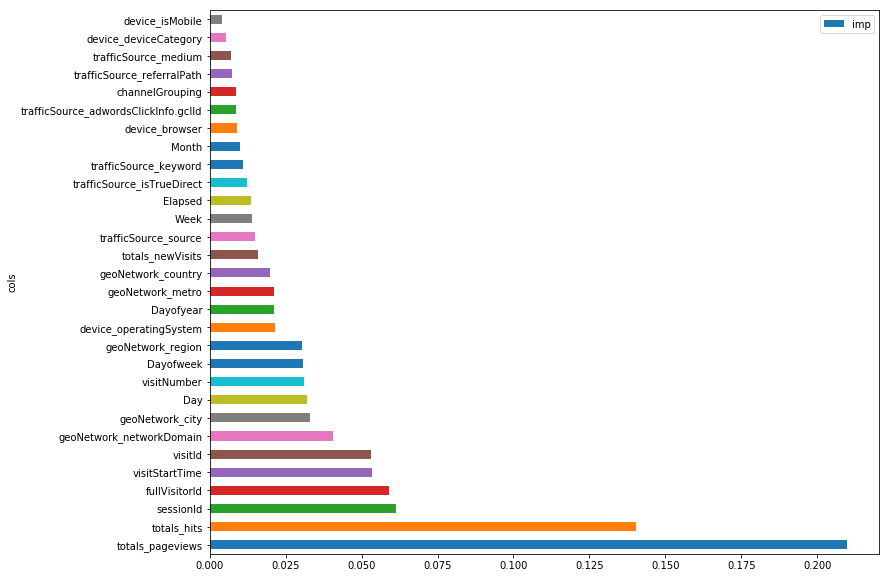

In [29]:
fi = rf_feat_importance(m, df_keep)
fi.plot(x='cols',y='imp',kind='barh',figsize=(12,10))

## One-hot encoding

In [228]:
df_trn2, y_trn, nas = proc_df(df_raw, 'Revenue', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

base_model()

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'r2_oob': 0.14143400023163688,
 'r2_train': 0.8774446657121954,
 'r2_valid': 0.183925242213556,
 'rmse_train': 0.6994609322713263,
 'rmse_valid': 2.0926530727684094}


Worse than feature important

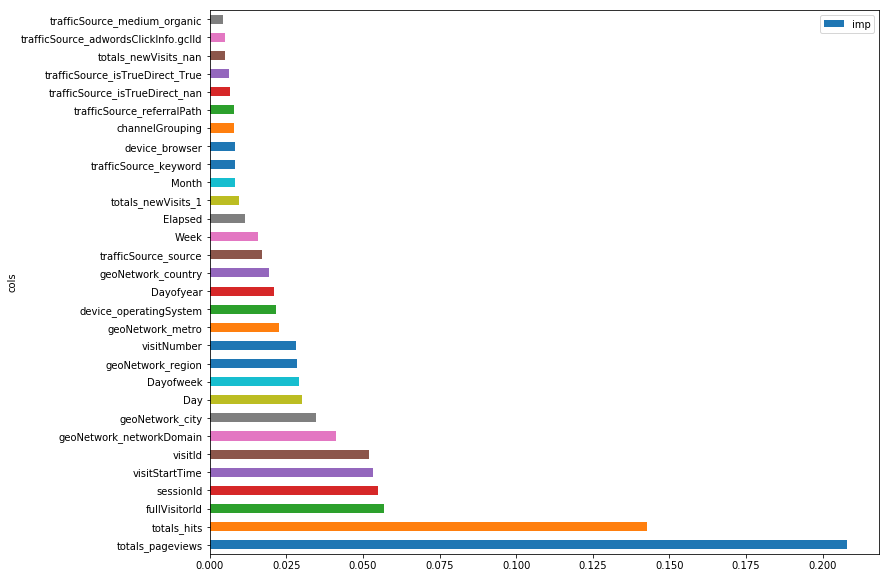

In [229]:
fi = rf_feat_importance(m, df_trn2)
fi[:30].plot(x='cols',y='imp',kind='barh',figsize=(12,10))

In [230]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep),len(fi.cols)
df_keep = df_trn2[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [231]:
base_model()

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'r2_oob': 0.1460282896213667,
 'r2_train': 0.8762962325134988,
 'r2_valid': 0.18323428457197233,
 'rmse_train': 0.7027305210090594,
 'rmse_valid': 2.0935387935219323}


Totally worse, not use

# Removing redundant features

In [45]:
from scipy.cluster import hierarchy as hc

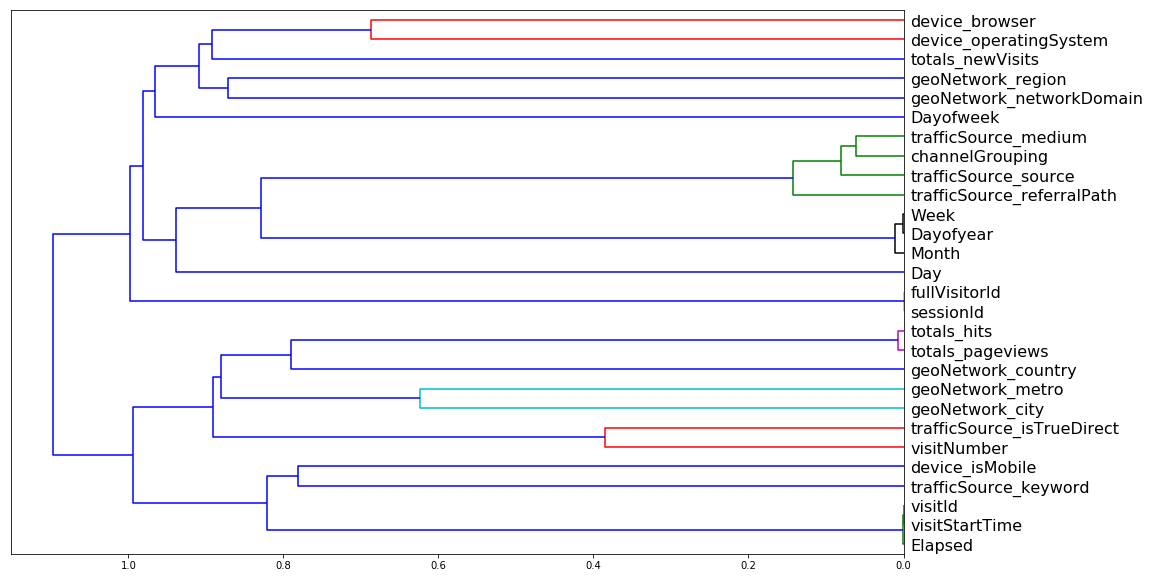

In [46]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [48]:
def get_oob(df):
    X_train, _ = split_vals(df, n_trn)
    base_model()
    

In [49]:
get_oob(df_keep)

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'r2_oob': 0.17242980721372558,
 'r2_train': 0.880205127054056,
 'r2_valid': 0.24023042085932012,
 'rmse_train': 0.6915386671793516,
 'rmse_valid': 2.0191715265128036}


In [92]:
to_drop = ['Week','Dayofyear','sessionId','fullVisitorId','visitId','visitStartTime','Elapsed']

for c in to_drop:
    print(c)
    c, get_oob(df_keep.drop(c, axis=1))
    print('-'*20)

Week
{'r2_oob': 0.14760207092311417,
 'r2_train': 0.8767753215319893,
 'r2_valid': 0.22196397493855224,
 'rmse_train': 0.7013684077699138,
 'rmse_valid': 2.0432999118997337}
--------------------
Dayofyear
{'r2_oob': 0.1649493589638963,
 'r2_train': 0.8771602426195634,
 'r2_valid': 0.2584230632463349,
 'rmse_train': 0.70027210687725,
 'rmse_valid': 1.9948505757048036}
--------------------
sessionId
{'r2_oob': 0.17540360703462865,
 'r2_train': 0.8823289058723516,
 'r2_valid': 0.24144149902490877,
 'rmse_train': 0.6853812965730205,
 'rmse_valid': 2.017561597740256}
--------------------
fullVisitorId
{'r2_oob': 0.17524918344309381,
 'r2_train': 0.8812155600050273,
 'r2_valid': 0.2538454195224047,
 'rmse_train': 0.6886160331440849,
 'rmse_valid': 2.0009980608239077}
--------------------
visitId
{'r2_oob': 0.16953853060879986,
 'r2_train': 0.8811752380897938,
 'r2_valid': 0.25798427957433134,
 'rmse_train': 0.6887329001401638,
 'rmse_valid': 1.9954406550194985}
--------------------
visitStar

Reset to full data

In [100]:
to_drop = ['sessionId']
get_oob(df_keep.drop(to_drop, axis=1))

{'r2_oob': 0.16616145285781336,
 'r2_train': 0.8807271939749435,
 'r2_valid': 0.2321506555192252,
 'rmse_train': 0.6900301566085407,
 'rmse_valid': 2.0298795673033494}


In [101]:
np.save('../data/keep_cols.npy', np.array(df_keep.columns))

In [102]:
keep_cols = np.load('../data/keep_cols.npy')
df_trn = df_trn[keep_cols]

# Tree interpreter

In [148]:
from treeinterpreter import treeinterpreter as ti

In [153]:
split_data(to_keep=to_keep)

In [154]:
row = X_valid.values[None,0]; row

array([[        10,         13, 1481325313,      63793,        176,      56931, 1481325313,          1,
                 1,        168,          9,         37,          1,          7,          4,         47,
               143,        344,         49,          0,          0,          6, 1481241600,         12,
                 7,          7,         52]])

In [155]:
prediction, bias, contributions = ti.predict(m, row)

In [156]:
prediction[0], bias[0]

(0.0, 0.2241080349644918)

In [157]:
idxs = np.argsort(contributions[0])

In [169]:
[o for o in zip(X_valid.columns[idxs], X_valid.iloc[0][idxs], contributions[0][idxs])]

[('visitNumber', 1, -0.1188410061415625),
 ('totals_newVisits', 1, -0.10272838755647958),
 ('geoNetwork_metro', 47, -0.040505980738313165),
 ('geoNetwork_city', 168, -0.024224704790433114),
 ('trafficSource_isTrueDirect', 0, -0.015451839333515896),
 ('visitStartTime', 1481325313, -0.013641331298145867),
 ('geoNetwork_region', 37, -0.01341846831009288),
 ('Dayofyear', 344, -0.008907937518178576),
 ('trafficSource_referralPath', 52, -0.008766472141050929),
 ('Day', 9, -0.008041369396346896),
 ('Dayofweek', 4, -0.008041005648257315),
 ('sessionId', 63793, -0.0025880439489683457),
 ('device_operatingSystem', 7, -0.002428901903688081),
 ('visitId', 1481325313, -0.0022529620116577428),
 ('Month', 12, -0.0016157311467578106),
 ('fullVisitorId', 56931, -0.0013448750094311901),
 ('device_browser', 6, -0.0008611380264629917),
 ('channelGrouping', 7, 0.0),
 ('trafficSource_source', 143, 0.0),
 ('totals_hits', 13, 0.0),
 ('trafficSource_keyword', 0, 0.0),
 ('Elapsed', 1481241600, 0.0),
 ('trafficS

In [176]:
contributions[0].sum()

-0.22410803496449178

# Extrapolation

In [199]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [200]:
m = RFF(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9995961214058343

In [201]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,Day,0.297363
17,Dayofyear,0.150790
6,visitId,0.134787
18,Week,0.130045
22,Elapsed,0.090825
2,visitStartTime,0.085950
14,Dayofweek,0.077444
23,Month,0.017291
1,totals_hits,0.004806
25,channelGrouping,0.004290


In [202]:
feats=['Day','Dayofyear','Week','visitStartTime']

In [203]:
(X_train[feats]/1000).describe()

,Day,Dayofyear,Week,visitStartTime
count,70000.000000,70000.000000,70000.000000,7.000000e+04
mean,0.015741,0.198955,0.028602,1.486267e+06
std,0.008610,0.105690,0.014961,9.185771e+03
min,0.001000,0.011000,0.002000,1.470899e+06
25%,0.011000,0.121000,0.018000,1.478989e+06
50%,0.014000,0.181000,0.026000,1.484351e+06
75%,0.023000,0.315000,0.045000,1.495220e+06
max,0.031000,0.348000,0.050000,1.501657e+06


In [204]:
(X_valid[feats]/1000).describe()

,Day,Dayofyear,Week,visitStartTime
count,30000.000000,30000.000000,30000.000000,3.000000e+04
mean,0.020471,0.253554,0.036297,1.481076e+06
std,0.007767,0.091851,0.013106,8.022509e+03
min,0.003000,0.062000,0.009000,1.471331e+06
25%,0.016000,0.229000,0.033000,1.474116e+06
50%,0.018000,0.261000,0.037000,1.480499e+06
75%,0.029000,0.335000,0.048000,1.481952e+06
max,0.030000,0.351000,0.050000,1.497769e+06


In [205]:
x.drop(feats, axis=1, inplace=True)

In [206]:
m = RFF(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9995872144890746

In [207]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
5,visitId,0.357696
18,Elapsed,0.326516
12,Dayofweek,0.168555
19,Month,0.128967
1,totals_hits,0.005864
21,channelGrouping,0.005203
22,trafficSource_referralPath,0.003016
0,totals_pageviews,0.002228
14,trafficSource_source,0.001263
8,geoNetwork_city,0.000135


In [220]:
feats=['visitId', 'Elapsed', 'Dayofweek','Day','Dayofyear','Week','visitStartTime',['Day','Dayofyear','Week','visitStartTime']]

In [221]:
X_train, X_valid = split_vals(df_keep, n_trn)
base_model()

{'r2_oob': 0.15816000454939705,
 'r2_train': 0.8801366787858633,
 'r2_valid': 0.25771713051036804,
 'rmse_train': 0.6917362042834944,
 'rmse_valid': 1.9957998334814453}


In [222]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    print(f)
    base_model()
    print('-'*20)

visitId
{'r2_oob': 0.19201498248749405,
 'r2_train': 0.881681842656715,
 'r2_valid': 0.24083481245019547,
 'rmse_train': 0.6872631394674626,
 'rmse_valid': 2.018368248045001}
--------------------
Elapsed
{'r2_oob': 0.17421577932379773,
 'r2_train': 0.8828518500580578,
 'r2_valid': 0.23878150217718275,
 'rmse_train': 0.683856643195282,
 'rmse_valid': 2.0210959401324824}
--------------------
Dayofweek
{'r2_oob': 0.16623977669397638,
 'r2_train': 0.8808370537560746,
 'r2_valid': 0.24462557828323062,
 'rmse_train': 0.6897122969533342,
 'rmse_valid': 2.013322747644048}
--------------------
Day
{'r2_oob': 0.15933157908383622,
 'r2_train': 0.8823044940186869,
 'r2_valid': 0.2472796428242401,
 'rmse_train': 0.6854523869302646,
 'rmse_valid': 2.009782655266682}
--------------------
Dayofyear
{'r2_oob': 0.16675394362788876,
 'r2_train': 0.8839213540990561,
 'r2_valid': 0.24904167156150026,
 'rmse_train': 0.6807278511151353,
 'rmse_valid': 2.0074289460657564}
--------------------
Week
{'r2_oob': 

In [223]:
df_trn = df_trn.drop(['Day', 'Dayofyear', 'Week', 'visitStartTime'],axis=1)
np.save('../data/to_keep.npy', np.array(df_trn.columns))

# Final model

In [227]:
X_train.columns

Index(['totals_pageviews', 'totals_hits', 'sessionId', 'geoNetwork_country',
       'fullVisitorId', 'visitId', 'geoNetwork_networkDomain', 'visitNumber',
       'geoNetwork_city', 'geoNetwork_region', 'totals_newVisits',
       'device_operatingSystem', 'Dayofweek', 'geoNetwork_metro',
       'trafficSource_source', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'device_browser', 'Elapsed', 'Month',
       'trafficSource_medium', 'channelGrouping',
       'trafficSource_referralPath'],
      dtype='object')

In [230]:
m = RFF(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 17.6 s, sys: 79 ms, total: 17.7 s
Wall time: 5.8 s
{'r2_oob': 0.28041256222461,
 'r2_train': 0.9012726844860759,
 'r2_valid': 0.2906379472442142,
 'rmse_train': 0.6277923468562588,
 'rmse_valid': 1.951040295804374}


In [236]:
params = {
    'n_estimators' : [20,40,60,80,160],
    'max_features': [None,.5,'log2','sqrt'],
    'min_samples_leaf' : [1,3,5,7,15]
}

In [242]:
%%time
grid_search = sklearn.model_selection.GridSearchCV(RFF(n_jobs=-1), param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

CPU times: user 36min 20s, sys: 13.2 s, total: 36min 33s
Wall time: 37min 5s
